text

In [1]:
# package set up
import pandas as pd
import plotly.express as px
import os
import json
import zipfile
import subprocess 
import matplotlib.pyplot as plt 

# machine learning
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, confusion_matrix, classification_report

In [2]:
# data download
data_dir = 'data'

# open kaggle.json
kaggle_token_path = 'kaggle.json'
with open(kaggle_token_path) as f:
    kaggle_token = json.load(f)
 
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump(kaggle_token, f)
 
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

 # download and unzip dataset
subprocess.call([
    'kaggle', 'datasets', 'download',
    '-d', 'clmentbisaillon/fake-and-real-news-dataset',
    '--path', data_dir,
    '--unzip'
])

0

In [3]:
# data upload

data_fake_news = pd.read_csv("data/Fake.csv")
data_true_news = pd.read_csv("data/True.csv")

# define news type
data_fake_news['news_type'] = 'fake'
data_true_news['news_type'] = 'true'
data_fake_news['outcome_fake_news'] = 1
data_true_news['outcome_fake_news'] = 0

# bind rows
data_all_news = pd.concat([data_fake_news, data_true_news], ignore_index=True)

# data cleaning
# are there duplicate headlines?
data_all_news['title'].duplicated().sum()
# remove duplicates
data_all_news = data_all_news.drop_duplicates(subset='title', keep='first')
# number of rows after removing duplicates
data_all_news.shape[0]

38729

In [ ]:
# pre-eliminary look (time series by new type)

# handle date formats
format_1 = data_all_news['date'].str.contains(',') #format like 'January 1, 2020' and 'Dec 31, 2019'
format_2 = data_all_news['date'].str.contains('-') #format like '19-Feb-2020'


data_all_news.loc[format_1, 'date'] = pd.to_datetime(data_all_news.loc[format_1, 'date'],
                                                    format='mixed')
# error generated by links instead of dates
data_all_news.loc[format_2, 'date'] = pd.to_datetime(data_all_news.loc[format_2, 'date'], format='%d-%b-%Y', errors='coerce') 
# counts by date and outcome using plotly 
counts = data_all_news.groupby(['date', 'news_type']).size().unstack(fill_value=0)

# plot counts of news by date and outcome
fig = px.line(counts, x=counts.index, y=counts.columns, title='Counts of News by Date and Outcome',
             labels={'value': 'Count', 'date': 'Date', 'news_type': 'News Type'})   

# change line colours 
fig.update_traces(line=dict(color='red'), selector=dict(name='fake'))
fig.update_traces(line=dict(color='green'), selector=dict(name='true'))

# add slider to select date range
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Count',
    xaxis_title='Date',
    legend_title='News Type',
    hovermode='x unified'
)

# change plot size
fig.update_layout(width=1300, height=500)

fig.show()

# NOTE: there's no point in time where fake news are more common (e..g, election periods), 
# instead they're produced at a somewhat constant rate whilst true news reflect the news cycle

In [5]:
# NOTE this is not useful as categories overlap
# counts of news by subject and type
counts = data_all_news.groupby(['subject', 'news_type']).size().unstack(fill_value=0)
counts

news_type,fake,true
subject,,
Government News,532,0
News,9049,0
US_News,783,0
left-news,705,0
politics,6834,0
politicsNews,0,11150
worldnews,0,9676


In [6]:
# re categorise subjects in data frame
data_all_news['subject_recategorised'] = data_all_news['subject'].replace({
    'worldnews' : 'News',
    'News': 'News',
    'US_News': 'News',
    'left-news': 'News',
    'Government News': 'Politics', # IMPORTANT: here we assume that 'Government News' is a subset of 'Politics'
    'politics': 'Politics',
    'politicsNews': 'Politics',
})

# IMPORTANT our x var will only have 2 levels
counts = data_all_news.groupby(['subject_recategorised', 'news_type']).size().unstack(fill_value=0)
counts

news_type,fake,true
subject_recategorised,,
News,10537,9676
Politics,7366,11150


In [7]:
# try simplest model, logistic regression
# keep only relevant columns
data_for_model = data_all_news[['subject_recategorised', 'outcome_fake_news']].copy()

# encode categorical variables
data_for_model = pd.get_dummies(data_for_model, columns=['subject_recategorised'], drop_first=True)

# split data into features and target
X = data_for_model.drop('outcome_fake_news', axis=1)
y = data_for_model['outcome_fake_news']

# divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<Axes: >

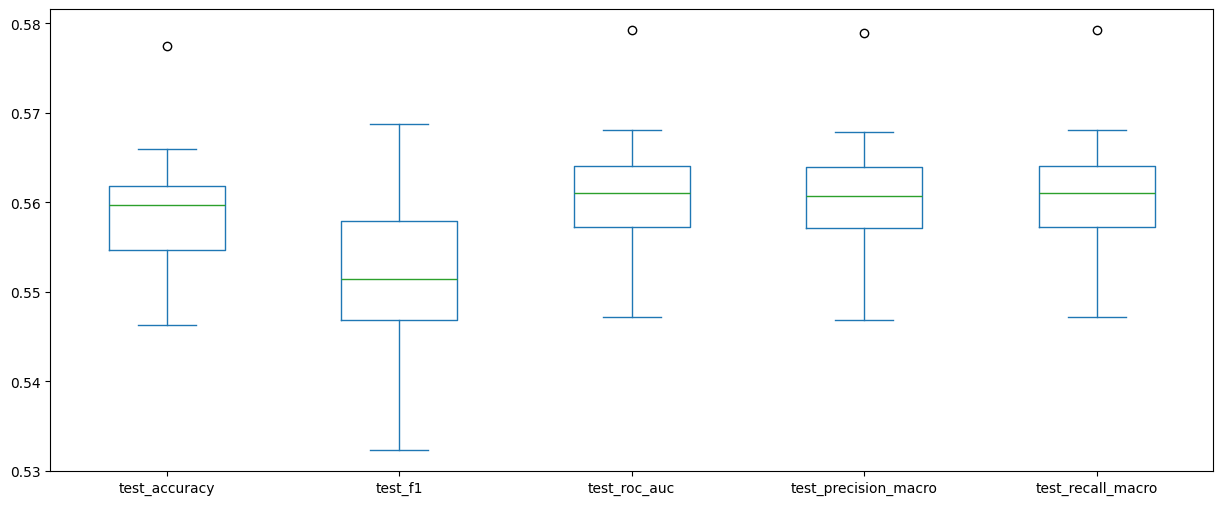

In [ ]:
#model training
model = LogisticRegression()

# kfold cross-validation
# this is important because it repeats breaking the data into training and test sets,
# so our training and prediction sets vary 
scores = cross_validate(model, X_train, y_train,
                       scoring=['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro'],
                       n_jobs=-1,
                       cv=10)

# on average, logistic regression not a great approach
scores_df = pd.DataFrame(scores)
scores_df.drop(columns=["fit_time", "score_time"]).plot(kind="box", figsize=(15, 6))

In [9]:
# predictions 
y_pred = cross_val_predict(model, 
                           X_train, 
                           y_train, 
                           cv=10)
# score evaluation
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.601033,0.521046,0.559423,0.561039,0.564041
recall,0.536476,0.586094,0.559423,0.561285,0.559423
f1-score,0.566923,0.551659,0.559423,0.559291,0.559864
support,15613.000000,13433.000000,0.559423,29046.000000,29046.000000


Text(0.5, 1.0, 'confusion matrix after applying 10-fold CV')

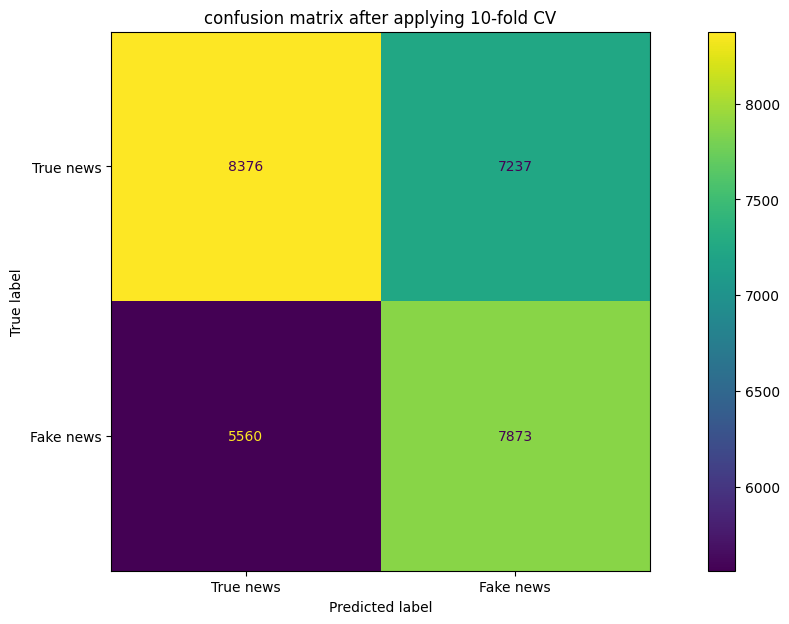

In [12]:
# this method doesn't perform well
# display misclassification in confusion matrix
fig, ax1 = plt.subplots(1, figsize=(15, 7))

ConfusionMatrixDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_pred,
    ax=ax1,
    display_labels=["True news", "Fake news"]
)

ax1.set_title("confusion matrix after applying 10-fold CV")


In [13]:
# IMPROVEMENT 
# IDEA: use text data to predict outcome using logistic regression
# so this should tell us if there are words commonly used in fake or true news
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Assume data_all_news has a text column and the outcome
texts = data_all_news['text']
y = data_all_news['outcome_fake_news']

# Create a pipeline to vectorise text and train logistic regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# kfold cross-validation
scores = cross_validate(pipeline, texts, y, 
                       scoring=['accuracy', 'f1', 'roc_auc', 'precision_macro', 'recall_macro'],
                       n_jobs=-1,
                       cv=10)


<Axes: >

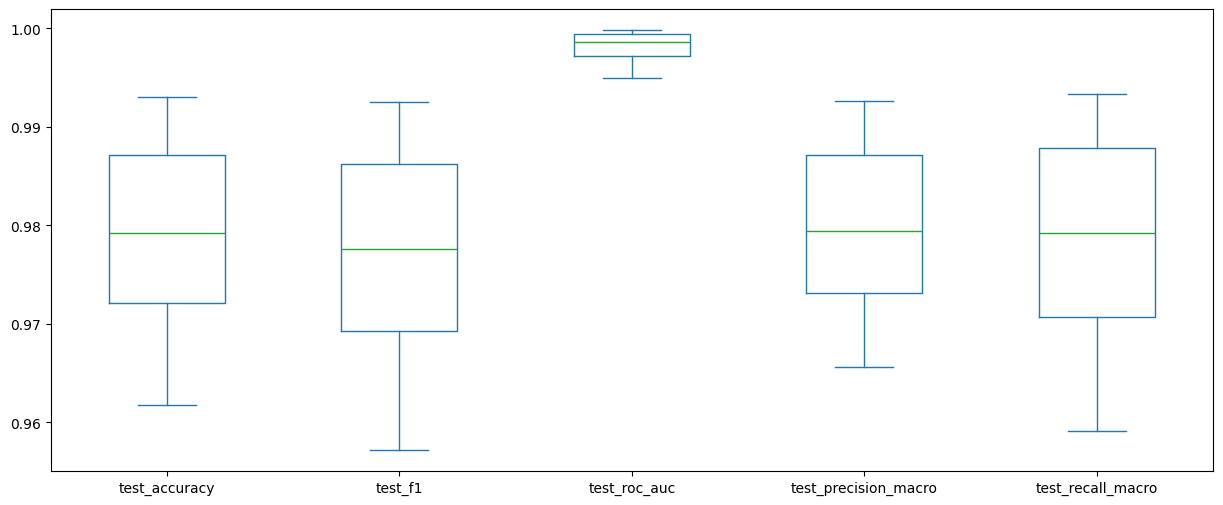

In [14]:
# we see much higher scores with this method
scores_df = pd.DataFrame(scores)
scores_df.drop(columns=["fit_time", "score_time"]).plot(kind="box", figsize=(15, 6))

Text(0.5, 1.0, 'confusion matrix after applying 10-fold CV')

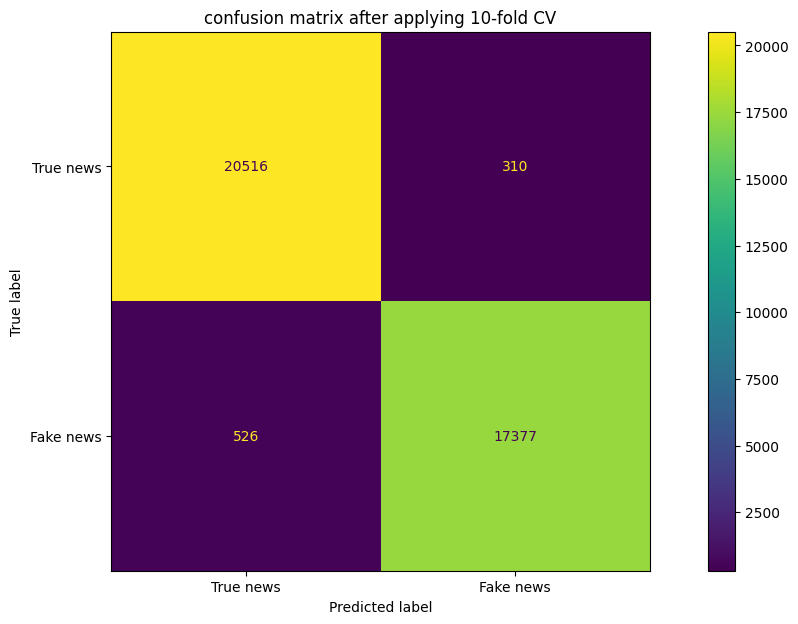

In [15]:
# predictions 
y_pred = cross_val_predict(pipeline, 
                           texts, 
                           y, 
                           cv=10)

# display confusion matrix showing improved classification
fig, ax1 = plt.subplots(1, figsize=(15, 7))

ConfusionMatrixDisplay.from_predictions(
    y_true=y,
    y_pred=y_pred,
    ax=ax1,
    display_labels=["True news", "Fake news"]
)
ax1.set_title("confusion matrix after applying 10-fold CV")

In [ ]:
# fit model and get coefficients
pipeline.fit(texts, y)
model = pipeline.named_steps['clf']
vectorizer = pipeline.named_steps['tfidf']

# Get feature names (words/tokens)
feature_names = vectorizer.get_feature_names_out()

# Get coefficients (array shape: [1, n_features])
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by absolute value of coefficient to find most important words
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

print(coef_df.head(20))

         feature  coefficient   abs_coef
3853     reuters   -26.675498  26.675498
3956        said   -17.963798  17.963798
4867  washington    -7.430057   7.430057
2256       image     6.768059   6.768059
2505        just     6.646220   6.646220
1775    featured     6.622664   6.622664
3649        read     6.408098   6.408098
4892   wednesday    -5.830074   5.830074
2008         gop     5.740923   5.740923
4673     tuesday    -5.703912   5.703912
4563    thursday    -5.327214   5.327214
947          com     4.995935   4.995935
2972          mr     4.987056   4.987056
3794  republican    -4.976605   4.976605
1980       getty     4.906169   4.906169
1921      friday    -4.756680   4.756680
2943      monday    -4.475598   4.475598
2161     hillary     4.464896   4.464896
3082         nov    -4.420371   4.420371
4871       watch     4.363214   4.363214


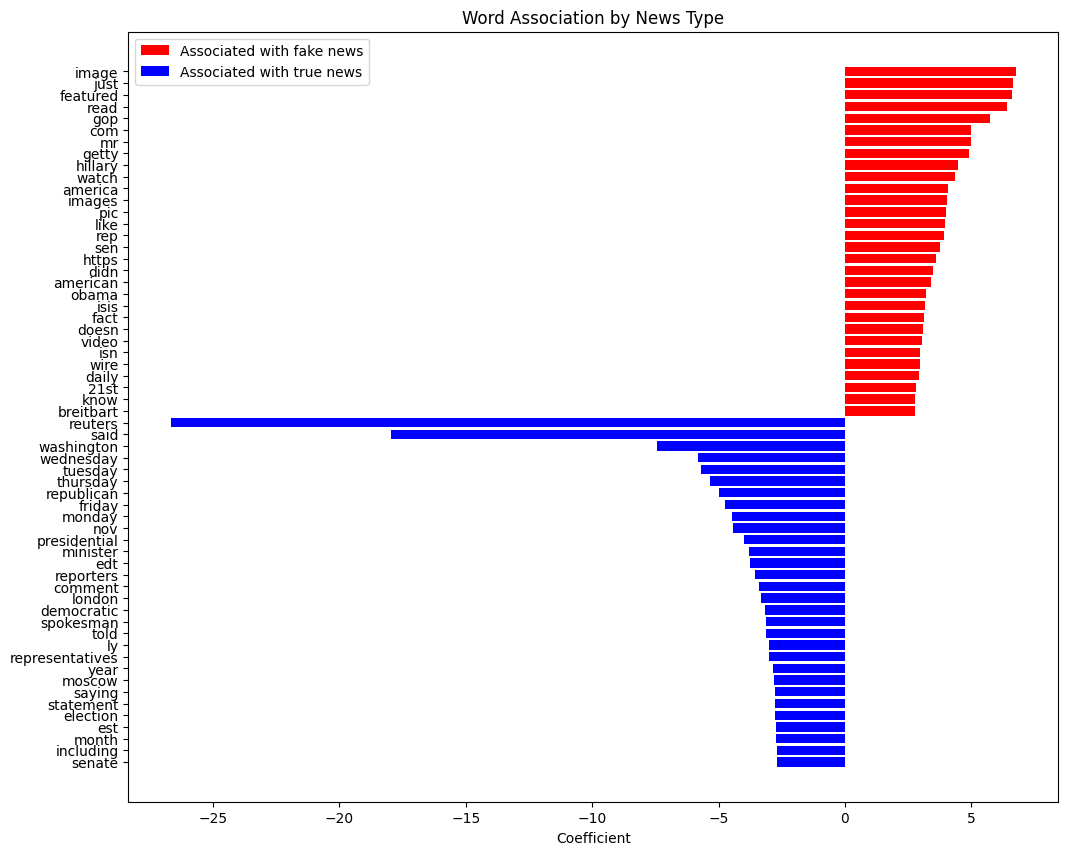

In [ ]:
# here we display the top words that predict each class
# number of words to display for each class
top_n = 30

# words that predict positive class (e.g. fake news)
top_positive = coef_df.sort_values(by='coefficient', ascending=False).head(top_n)

# Words that predict negative class (e.g. real news)
top_negative = coef_df.sort_values(by='coefficient').head(top_n)

plt.figure(figsize=(12,10))

# Plot positive coefficients
plt.barh(top_positive['feature'], top_positive['coefficient'], color='red', label='Associated with fake news')

# Plot negative coefficients
plt.barh(top_negative['feature'], top_negative['coefficient'], color='blue', label='Associated with true news')

plt.xlabel('Coefficient')
plt.title('Word Association by News Type')
plt.legend()
plt.gca().invert_yaxis()
plt.show()
